# ДЗ 5. Случайный лес

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.tree import DecisionTreeClassifier

## № 1. 

* Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, 
* обучить случайный лес из 1, 3, 10 и 50 деревьев и 
* визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 

Возьмем 3 переменные - 2 из них информативны

In [3]:
X, y = datasets.make_classification(n_samples=100, n_features=3, n_informative=2, n_redundant=1, n_repeated=0, 
                                   n_clusters_per_class=2, random_state=2)

In [4]:
from scipy.stats import pearsonr

Глянем на попарную корреляцию

In [5]:
pearsonr(X[:, 0], X[:, 1]), pearsonr(X[:, 0], X[:, 2]), pearsonr(X[:, 1], X[:, 2])

((-0.1945354951988246, 0.052444297670454734),
 (-0.7109601126236798, 1.1612012591501722e-16),
 (-0.5514904415350284, 2.7401041475462326e-09))

Посмотрим, что построили

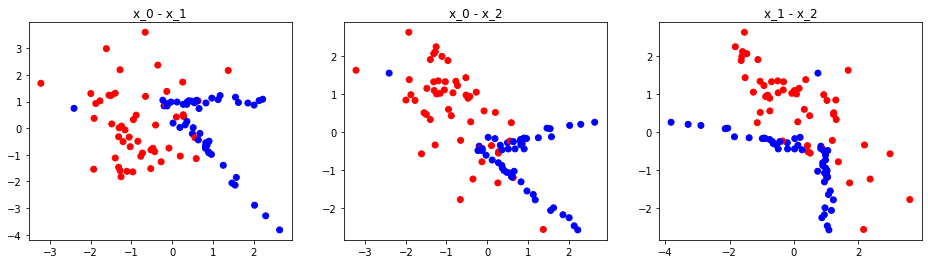

In [6]:
# визуализируем сгенерированные данные
plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])


plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=y, cmap=colors)
plt.title('x_0 - x_1')


plt.subplot(1, 3, 2)
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[2], X)), 
              c=y, cmap=colors)
plt.title('x_0 - x_2')



plt.subplot(1, 3, 3)
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.scatter(list(map(lambda x: x[1], X)), list(map(lambda x: x[2], X)), 
              c=y, cmap=colors)
plt.title('x_1 - x_2')
plt.show()

Здесь решил построить все три графика, и раз такое дело, сразу __вопрос:__

На уроке делали только один - зависимость 0-й и 1-й переменной, а в чем смысл? У нас же было 5 независимых переменных, что именно мы хотели увидеть по взаимосвязи только 2-х?


In [7]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 3, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

### Подготовка

Bootstrap + subsample + tree/forest structure

In [8]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [9]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [10]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [11]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [12]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [13]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [14]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [15]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [16]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [17]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [18]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [19]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [20]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [21]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [22]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Приступим к самому обучению

In [23]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [24]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [25]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [26]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [27]:
# Точность на обучающей выборке
train_accuracy1 = accuracy_metric(train_labels, train_answers)
test_accuracy1 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей / тестовой выборке: {train_accuracy1:.3f} / {test_accuracy1:.3f}')

Точность случайного леса из 1 деревьев на обучающей / тестовой выборке: 88.571 / 70.000


Построим лес из трех деревьев

In [28]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [29]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [30]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [31]:
# Точность на обучающей выборке
train_accuracy3 = accuracy_metric(train_labels, train_answers)
test_accuracy3 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей / тестовой выборке: {train_accuracy3:.3f} / {test_accuracy3:.3f}')

Точность случайного леса из 3 деревьев на обучающей / тестовой выборке: 100.000 / 90.000


Построим лес из десяти деревьев

In [32]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [33]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [34]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [35]:
# Точность на обучающей выборке
train_accuracy10 = accuracy_metric(train_labels, train_answers)
test_accuracy10 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей / тестовой выборке: {train_accuracy10:.3f} / {test_accuracy10:.3f}')

Точность случайного леса из 10 деревьев на обучающей / тестовой выборке: 100.000 / 90.000


Построим лес из пятидесяти деревьев

In [36]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [37]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [38]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [39]:
# Точность на обучающей выборке
train_accuracy50 = accuracy_metric(train_labels, train_answers)
test_accuracy50 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей / тестовой выборке: {train_accuracy50:.3f} / {test_accuracy50:.3f}')

Точность случайного леса из 50 деревьев на обучающей / тестовой выборке: 100.000 / 93.333


(17554, 1) (17554, 1) (17554, 1)
(17554, 1) (17554, 1) (17554, 1)


/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:34: Mat

(17554, 1) (17554, 1) (17554, 1)


/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


(17554, 1) (17554, 1) (17554, 1)


/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:62: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:68: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=93.33')

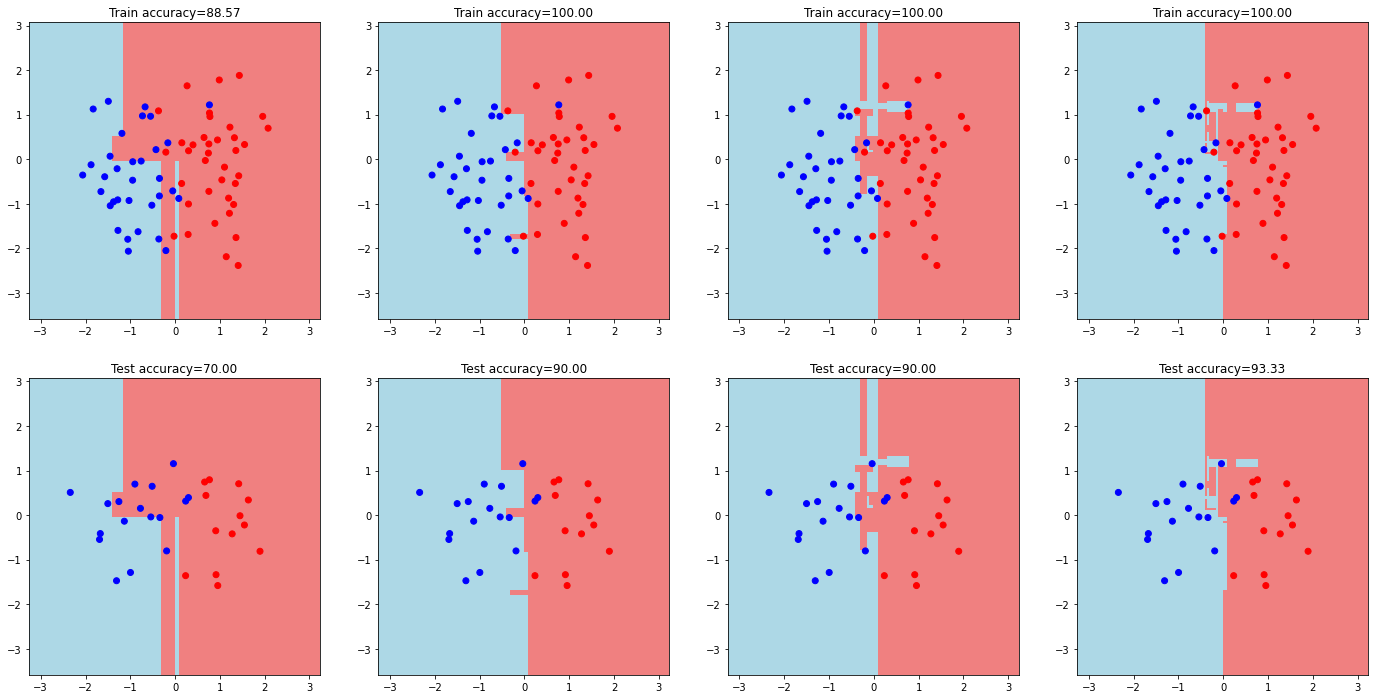

In [40]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (24, 12))

# график обучающей выборки
plt.subplot(2,4,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_1,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy1:.2f}')

# график тестовой выборки
plt.subplot(2,4,4+1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy1:.2f}')

# график обучающей выборки
plt.subplot(2,4,2)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_3,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy3:.2f}')

# график тестовой выборки
plt.subplot(2,4,4+2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy3:.2f}')

# график обучающей выборки
plt.subplot(2,4,3)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_10,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy10:.2f}')

# график тестовой выборки
plt.subplot(2,4,4+3)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy10:.2f}')

# график обучающей выборки
plt.subplot(2,4,4)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_50,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy50:.2f}')

# график тестовой выборки
plt.subplot(2,4,4+4)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy50:.2f}')

Я позволил себе усомниться, что даже в ансамбле деревью стоит так сильно переобучивать, и поменял мин количество объектов в листе с 1 до 2. Это привело лишь к улучшению ситуации у одиночного дерева (на тесте), но ухудшению у всех остальных. Дальнейший анализ для минимального кол-ва 1, как и на занятии

## №2 Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

1) __1 дерево__ - 92% / 90%

На самом деле, числа, конечно, разные все время, но это из-за бутстрапа - других случайностей у нас нет. 
Слабое обучение, но переобучение небольшое

2) __3 дерева__ - 97% / 90%

На трэйне неплохо, но переобучение

3) __10 деревьев__ - 100%/93%

Аналогично

4) __50 деревьев__ - 100%/93%

Аналогично



__Структура результирующих деревьев__

Наблюдается усложнение структуры с ростом числа деревьев. Чисто внешне очень напрашивается слово "переобучение", но по численным результатам этого не скажешь

## №3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Для этого в функции создания леса будем возвращать бутстрапированную выборку:

In [41]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
#        print(f'Bootstraped: ', len(set(b_data)))
        forest.append(build_tree(b_data, b_labels))
        
    return forest, bootstrap

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

В качестве функции потерь, оставим сумму индикаторов неверных предсказаний

### Уточнение

Здесь хотел бы пройтись еще раз письменно. Дело в том, что раз 10 пересмотрел видео, не меньше перечитал формулу и описание. Поправьте, пожалуйста, если ошибаюсь. Алгоритм такой:

* Перебираем все наблюдения
* Для конкретного наблюдения $x_i$ собираем все деревья, в чьих обучениях оно не участвовало. Делаем предсказание, и находим среднее кол-во ошибок
* Все это дело суммируем, __не усредняя__

Таким образом мы можем получить OOB > 1 (и получим дальше, верно?). Например, для леса из одного дерева достаточно ошибиться > 1 раза

In [42]:
def OOB(forest, bootstrap, data, labels):
    sum_outer = 0
    for j, unit in enumerate(data):
        # для каждого наблюдения соберем предсказания деревьев, где оно не обучало
        counter = 0
        oob_forest = []
        sum_inner = 0
        for i, tree in enumerate(forest):
            if unit not in bootstrap[i][0]:
                counter += 1
                oob_forest.append(tree)
        # Собрали деревья для конкретного наблюдения
        for i, tree in enumerate(oob_forest):
            data_train = []
            data_train.append(unit)
            if (predict(data_train, tree) != labels[j]):
                #print(f'Error in tree №{i} out of {len(oob_forest)} for data №{j}')
#                    sum_inner += (predict(data_train, tree) == labels[j])[0]
                sum_inner += 1
        # Если вдруг для этого наблюдения не нашлось ни одного дерева, пропускаем
        if len(oob_forest) == 0:
            continue
        sum_outer += sum_inner/len(oob_forest)
    return sum_outer

In [43]:
n_trees = 1
my_forest_1, bootstrap_1 = random_forest(classification_data, classification_labels, n_trees)

In [44]:
OOB(my_forest_1, bootstrap_1, classification_data, classification_labels)

4.0

In [45]:
n_trees = 3
my_forest_3, bootstrap_3 = random_forest(classification_data, classification_labels, n_trees)

In [46]:
OOB(my_forest_3, bootstrap_3, classification_data, classification_labels)

15.5

In [47]:
n_trees = 10
my_forest_10, bootstrap_10 = random_forest(classification_data, classification_labels, n_trees)

In [48]:
OOB(my_forest_10, bootstrap_10, classification_data, classification_labels)

16.01666666666667

In [49]:
n_trees = 50
my_forest_50, bootstrap_50 = random_forest(classification_data, classification_labels, n_trees)

In [50]:
OOB(my_forest_50, bootstrap_50, classification_data, classification_labels)

15.775705409179297

## №4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

In [51]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [52]:
# Расчет критерия Шеннона

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0.
    for label in classes:
        p = classes[label] / len(labels)
        if p == 0:
            continue
        else:
            impurity -= p * np.log2(p)
    return impurity

In [53]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [54]:
# Расчет качества

def quality_entropy(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [55]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    print('bootstraped')
    
    for b_data, b_labels in bootstrap:
#        print(f'Bootstraped: ', len(set(b_data)))
        forest.append(build_tree(b_data, b_labels))
    print(f"{len(forest)} trees appended")
        
    return forest#, bootstrap

In [56]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [57]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

bootstraped
1 trees appended


In [58]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [59]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [60]:
# Точность на обучающей выборке
train_accuracy1 = accuracy_metric(train_labels, train_answers)
test_accuracy1 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей / тестовой выборке: {train_accuracy1:.3f} / {test_accuracy1:.3f}')

Точность случайного леса из 1 деревьев на обучающей / тестовой выборке: 97.143 / 90.000


Построим лес из трех деревьев

In [61]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

bootstraped
3 trees appended


In [62]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [63]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [64]:
# Точность на обучающей выборке
train_accuracy3 = accuracy_metric(train_labels, train_answers)
test_accuracy3 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей / тестовой выборке: {train_accuracy3:.3f} / {test_accuracy3:.3f}')

Точность случайного леса из 3 деревьев на обучающей / тестовой выборке: 97.143 / 93.333


Построим лес из десяти деревьев

In [65]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

bootstraped
10 trees appended


In [66]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [67]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [68]:
# Точность на обучающей выборке
train_accuracy10 = accuracy_metric(train_labels, train_answers)
test_accuracy10 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей / тестовой выборке: {train_accuracy10:.3f} / {test_accuracy10:.3f}')

Точность случайного леса из 10 деревьев на обучающей / тестовой выборке: 100.000 / 90.000


Построим лес из пятидесяти деревьев

In [69]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

bootstraped
50 trees appended


In [70]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [71]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [72]:
# Точность на обучающей выборке
train_accuracy50 = accuracy_metric(train_labels, train_answers)
test_accuracy50 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей / тестовой выборке: {train_accuracy50:.3f} / {test_accuracy50:.3f}')

Точность случайного леса из 50 деревьев на обучающей / тестовой выборке: 100.000 / 93.333


(17554, 1) (17554, 1) (17554, 1)


/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


(17554, 1) (17554, 1) (17554, 1)


/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


(17554, 1) (17554, 1) (17554, 1)


/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


(17554, 1) (17554, 1) (17554, 1)


/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:62: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_66813/63898131.py:68: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=93.33')

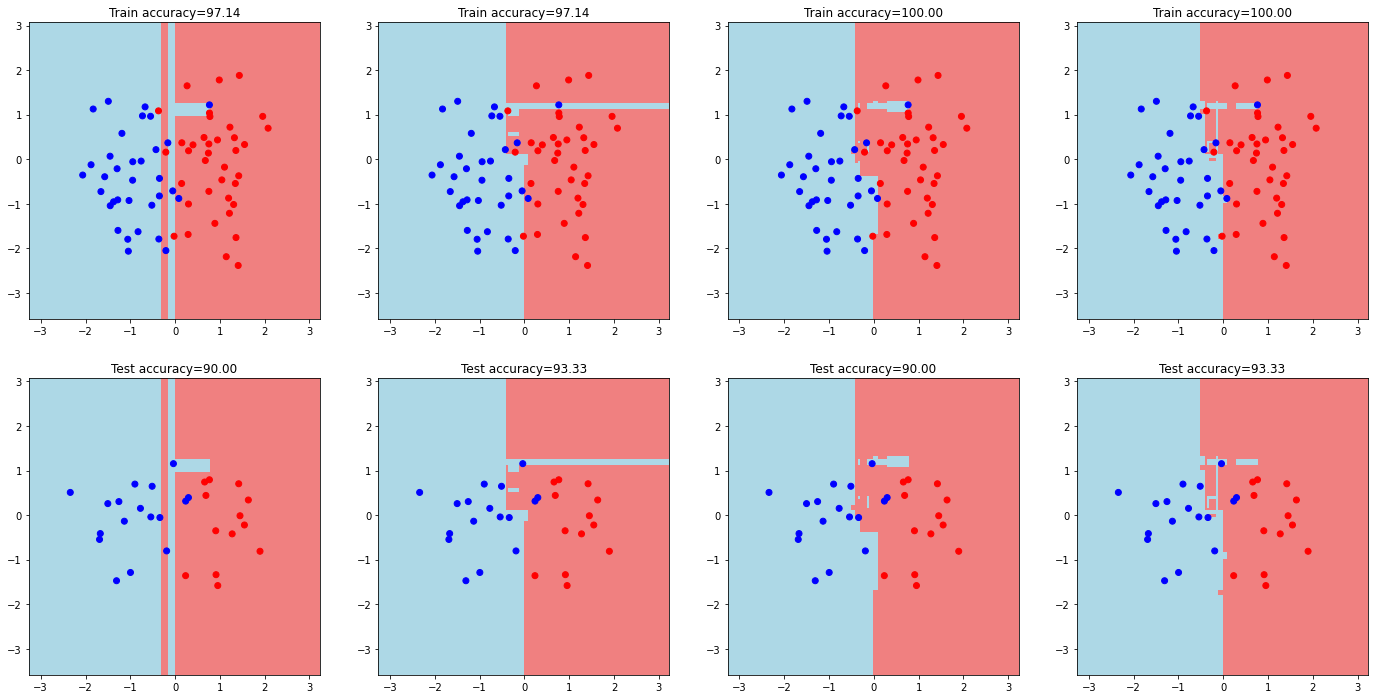

In [73]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (24, 12))

# график обучающей выборки
plt.subplot(2,4,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_1,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy1:.2f}')

# график тестовой выборки
plt.subplot(2,4,4+1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy1:.2f}')

# график обучающей выборки
plt.subplot(2,4,2)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_3,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy3:.2f}')

# график тестовой выборки
plt.subplot(2,4,4+2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy3:.2f}')

# график обучающей выборки
plt.subplot(2,4,3)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_10,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy10:.2f}')

# график тестовой выборки
plt.subplot(2,4,4+3)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy10:.2f}')

# график обучающей выборки
plt.subplot(2,4,4)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_50,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy50:.2f}')

# график тестовой выборки
plt.subplot(2,4,4+4)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy50:.2f}')

### Вывод

Прироста качества на тесте не наблюдаем

